In [290]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union, List
from scipy.interpolate import Rbf, interp1d
import pandas as pd


plt.rcParams["font.family"] = "century"

# Data loading

In [310]:
class Well:
    def __init__(self, filepath_dtp=None, filepath_rhob=None, delimiter="\t", dtype=np.single):
        """
        Constructor for the Well class.

        Parameters:
        - filepath_dtp: Filepath for the sonic log (dtp).
        - filepath_rhob: Filepath for the density log (rhob).
        - delimiter: Delimiter used in the log files. Default is '\t' (tab).
        - dtype: Data type to be used when reading the log files. Default is np.single.
        """
        self.filepath_dtp = filepath_dtp
        self.filepath_rhob = filepath_rhob
        
        if self.filepath_dtp is not None and self.filepath_rhob is not None:
            if not (os.path.isfile(self.filepath_dtp) and self.filepath_dtp.endswith('.txt') and
                    os.path.isfile(self.filepath_rhob) and self.filepath_rhob.endswith('.txt')):
                print("TXT-logfile not found or invalid file extension.")
                self._initialize_empty()
                return

            self.name_dtp = os.path.basename(self.filepath_dtp)
            self.name_rhob = os.path.basename(self.filepath_rhob)

            self.index = int(re.search(r'\d+', self.name_dtp).group())

            self.data = {'dtp': None, 'rhob': None}

            try:
                self.data['dtp'] = self._read_txt(self.filepath_dtp, delimiter, dtype)
                self.data['rhob'] = self._read_txt(self.filepath_rhob, delimiter, dtype)
                print("--File uploading has passed successfully--")
            except Exception as e:
                print(f"Error reading data from files: {e}")
                self._initialize_empty()
        else:
            print("Filepaths not provided.")

    def _read_txt(self, filepath, delimiter, dtype):
        """
        Method to read data from a text file and return it as a numpy array.
        """
        with open(filepath, "r") as txt:
            next(txt)  # Skip header
            data = np.loadtxt(txt, delimiter=delimiter, dtype=dtype)

        return data
    
    def _initialize_empty(self):
        """
        Method to initialize attributes to None when file reading fails.
        """
        self.data = {'dtp': None, 'rhob': None}
        self.name_dtp = None
        self.name_rhob = None
        self.index = None

    def __repr__(self):
        """
        String representation of the Well object.
        """
        return f'name_dtp: {self.name_dtp}\nname_rhob: {self.name_rhob}\nindex: {self.index}\n'


In [311]:
def divide_filenames_by_keyword(directory):
    dtp_files = []
    rhob_files = []

    for filename in os.listdir(directory):
        # Convert filename to lowercase for case-insensitive matching
        lowercase_filename = filename.lower()
        if "dtp" in lowercase_filename:
            dtp_files.append(os.path.join(directory, filename))
        elif "rhob" in lowercase_filename:
            rhob_files.append(os.path.join(directory, filename))

    return dtp_files, rhob_files

In [352]:
folder = r"C:\Users\Владислав\Downloads\LOG _unique"
dtp_dir, rhob_dir = divide_filenames_by_keyword(folder)

dir_df = pd.DataFrame({"dtp": dtp_dir, "rhob" : rhob_dir})
dir_df

,dtp,rhob
0,C:\Users\Владислав\Downloads\LOG _unique\Болтн...,C:\Users\Владислав\Downloads\LOG _unique\Болтн...
1,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
2,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
3,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
4,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
5,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
6,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
7,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
8,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...
9,C:\Users\Владислав\Downloads\LOG _unique\Казан...,C:\Users\Владислав\Downloads\LOG _unique\Казан...


In [353]:
wells = []
for i in range(dir_df.shape[0]):
    wells.append(Well(dir_df.iloc[i, :]["dtp"], dir_df.iloc[i, :]["rhob"]))
 

--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uplo

In [354]:
wells[4]

name_dtp: Казанская 19р_DTp.txt
name_rhob: Казанская 19р_RHOB.txt
index: 19

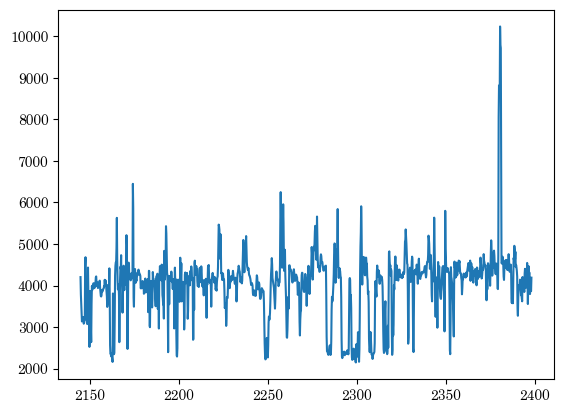

In [355]:
plt.plot(wells[2].data["dtp"][:, 2], 1e6/wells[2].data["dtp"][:, 3])

In [356]:
def r2even(f):
    if (np.floor(f)%2 == 0): 
        return np.floor(f)
    else: 
        return np.floor(f)+1
    
def interp(x: np.ndarray, y: np.ndarray, step: float, kind="cubic", fill_value="extrapolate"):
    """
    func takes 2 numpy.arrays (x,y by default) and desired step for the first array
    than, it interpolates values y for new x:

    input:
    x -> np.array([1, 2, 3, 4, 5, 6])
    y -> np.array([10, 15, 20, 25, 30, 35])
    step - > 1.5

    output:
    x_new -> np.array([1, 2.5, 4, 5.5])
    y_new -> np.array([10, 17.5, 25, 32.5])

    you can also adjust the inner parameters of the interplate.interp1d func (kind, fill_value)
    which are "cubic" and "extrapolate" by default
    """
    #exceptions
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Input 'x' and 'y' must be NumPy arrays")
    if x.shape != y.shape:
        raise ValueError("Input 'x' and 'y' must have the same shape")

    #functional block       
    f = interp1d(x, y, kind=kind, fill_value=fill_value)
    xnew = np.arange(r2even(x[0]), r2even(x[-1])+1, step)
    ynew = f(xnew)
    return xnew, ynew

In [357]:
"""np.r_ is a short concatenation method"""
dtp_decimated = [np.r_['r', interp(wells[i].data["dtp"][:, 2], 1e6/wells[i].data["dtp"][:, 3], 2, kind = "nearest")].T for i in range(len(dtp))]
rhob_decimated = [np.r_['r', interp(wells[i].data["rhob"][:, 2], wells[i].data["rhob"][:, 3], 2, kind = "nearest")].T for i in range(len(dtp))]

In [359]:
for i in range(len(dtp)):
    len_rhob = len(rhob_decimated[i])
    len_dtp = len(dtp_decimated[i])

    if (len_dtp > len_rhob):
        dtp_decimated[i] = dtp_decimated[i][:len_rhob, :] 
    else:
        rhob_decimated[i] = rhob_decimated[i][:len_dtp, :]



In [366]:
"""
18/04/2024
Закончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух
Дальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс
Пришить это все к глубинам 
Расчитать inline/crossline для каждой скважины (интерполяция инклинометрии)
31 индекс косячный, посмотреть (kaz_K21_294)

19/04/2024
Переписал логику под ООП, теперь каждая скважина - объект, имеющий свои атрибуты. 
Так удобно работать, больше контроля над данными и можно избежать тупых факапов 
(как например с переводом медленности в скорость)
Перевел скорости в медленности и расчитал импеданс для каждой скважины,
запросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла

Даль


""" 

'\n18/04/2024\nЗакончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух\nДальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс\nПришить это все к глубинам \nРасчитать inline/crossline для каждой скважины (интерполяция инклинометрии)\n31 индекс косячный, посмотреть (kaz_K21_294)\n\n19/04/2024\nПереписал все в ООП, теперь каждая скважина - объект, имеющий свои атрибуты. \nТак удобно работать, больше контроля над данными и можно избежать тупых факапов \n(как например с переводом медленности в скорость)\nПеревел скорости в медленности и расчитал импеданс для каждой скважины,\nзапросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла\n\n'

In [361]:
ai_decimated = [np.array(dtp_decimated[i][:, 1])*np.array(rhob_decimated[i][:, 1]) for i in range(len(dtp))]

In [362]:
for i in range(dir_df.shape[0]):
    wells[i].data_decimated = {"dtp": dtp_decimated[i], "rhob": rhob_decimated[i]}
    wells[i].impedance = ai_decimated[i]

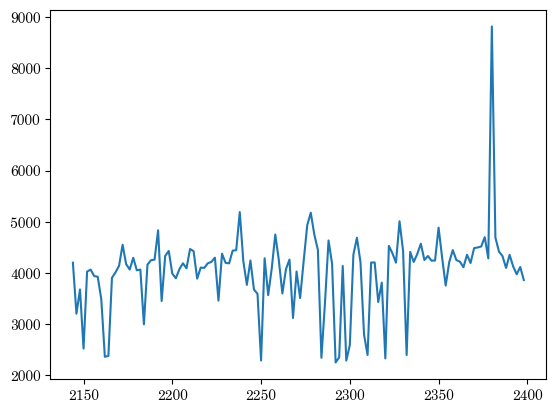

In [363]:
plt.plot(wells[2].data_decimated["dtp"][:, 0], wells[2].data_decimated["dtp"][:, 1])

['16']


Text(0, 0.5, 'value')

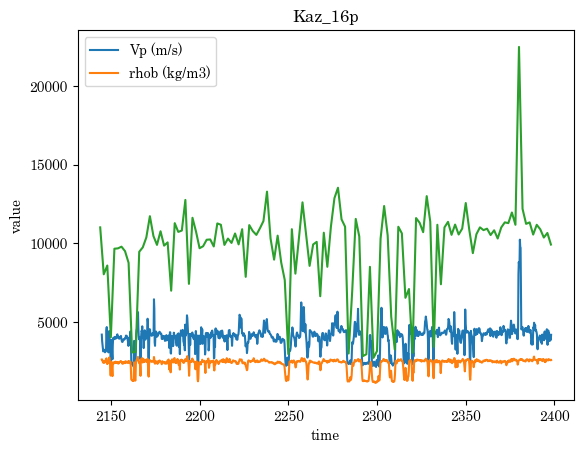

In [350]:
w_num =  2
print(dtp_labels[w_num])

plt.plot(dtp[w_num][:, 2], 1e6/dtp[w_num][:, 3], label = "Vp (m/s)")

# plt.plot(dtp_decimated[w_num][:, 0], dtp_decimated[w_num][:, 1])

plt.plot(rhob[w_num][:, 2], 1e3*rhob[w_num][:, 3], label = "rhob (kg/m3)")

plt.plot(dtp_decimated[w_num][:, 0], ai_decimated[w_num])

# plt.plot(dtp_decimated[w_num][:, 0], ai_decimated[w_num][:, 1])
# plt.ylim([0, 3])
plt.legend(loc = 0)
plt.title("Kaz_%2sp" % dtp_labels[w_num][0])
plt.xlabel("time")
plt.ylabel("value")

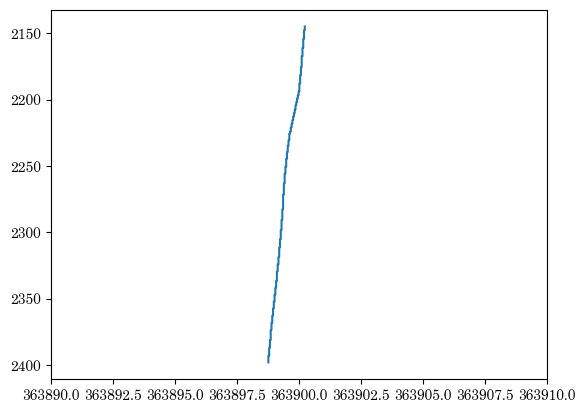

In [351]:
plt.plot(dtp[2][:, 0], dtp[2][:, 2])
plt.xlim([3.6389*1e5, 3.6391*1e5])
plt.gca().invert_yaxis()